In [1]:
%matplotlib inline

In [2]:
import os
import os.path as osp
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tools import save_obj, load_obj

In [3]:
RELIABILITY_DATA_ROOT_CF10 = "./data/reliability_cifar10"

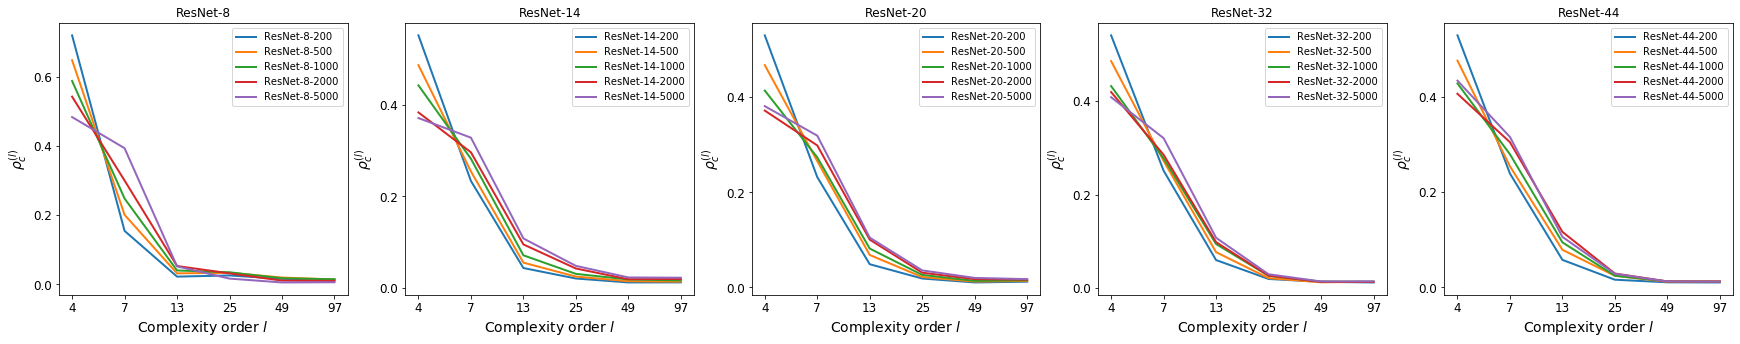

In [5]:
def get_component_data(model):
    sizes = [200, 500, 1000, 2000, 5000]
    result = []
    for size in sizes:
        model_size = f"{model}_{size}"
        data_dict = load_obj(osp.join(RELIABILITY_DATA_ROOT_CF10, f"{model_size}_data.bin"))
        normalized_var_component = list(data_dict["train"]["var_normal_new"].values())
        normalized_var_component = [var / data_dict["train"]["var_teacher"][1] for var in normalized_var_component]
        result.append(normalized_var_component)
    return result


def plot_component():
    models = ["resnet8", "resnet14", "resnet20", "resnet32", "resnet44"]
    sizes = [200, 500, 1000, 2000, 5000]
    plt.figure(figsize=(30, 5))
    subplot = 1
    for model in models:
        data = get_component_data(model)
        plt.subplot(1, 5, subplot)
        subplot += 1
        x = range(len(data[0]))
        plt.title(f"ResNet-{model[6:]}")
        plt.xticks(x, [4, 7, 13, 25, 49, 97])
        plt.tick_params(labelsize=12)
        plt.xlabel(r"Complexity order $l$", size=14)
        plt.ylabel(r"$\rho_c^{(l)}$", size=14)
        for i, size in enumerate(sizes):
            plt.plot(x, data[i], label=f"ResNet-{model[6:]}-{size}", linewidth=2.0)
            ax = plt.gca()
            ax.yaxis.set_major_locator(MultipleLocator(0.2))
        plt.legend()
    plt.show()

plot_component()

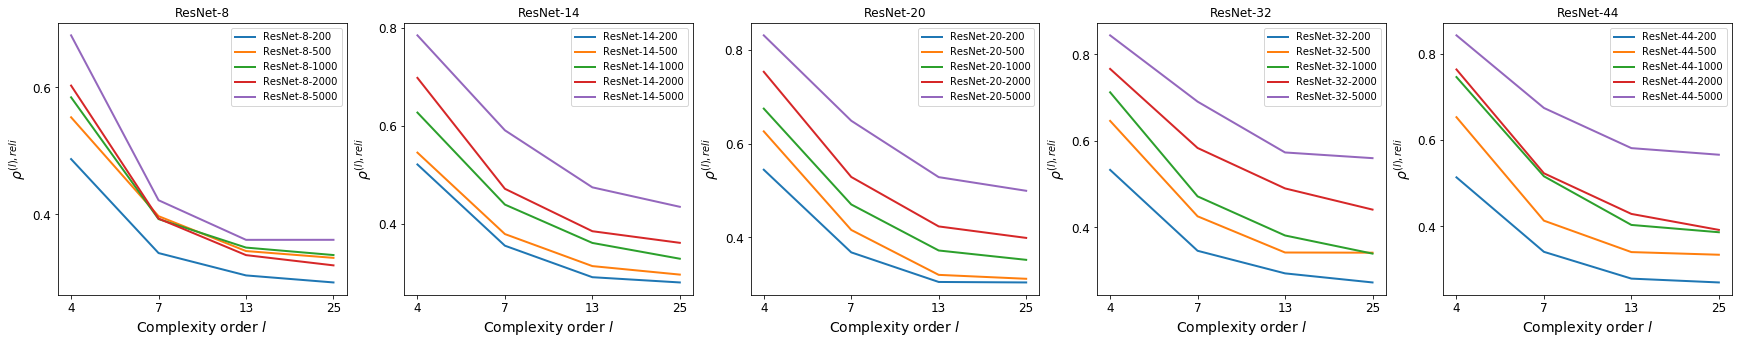

In [7]:
def get_reliability_data(model):
    sizes = [200, 500, 1000, 2000, 5000]
    result = []
    for size in sizes:
        model_size = f"{model}_{size}"
        data_dict = load_obj(osp.join(RELIABILITY_DATA_ROOT_CF10, f"{model_size}_data.bin"))
        reliable_data = list(data_dict["train"]["var_agaf_current"].values())
        feature_data = list(data_dict["train"]["var_normal_current"].values())
        reli_all = [reli/feature for feature, reli in zip(feature_data, reliable_data)]
        result.append(reli_all[:-2])
    return result

def plot_reliability():
    models = ["resnet8", "resnet14", "resnet20", "resnet32", "resnet44"]
    sizes = [200, 500, 1000, 2000, 5000]
    plt.figure(figsize=(30, 5))
    subplot = 1
    for model in models:
        data = get_reliability_data(model)
        plt.subplot(1, 5, subplot)
        plt.title(f"ResNet-{model[6:]}")
        subplot += 1
        x = range(len(data[0]))
        plt.xticks(x, [2**i*3+1 for i in x])
        plt.tick_params(labelsize=12)
        plt.xlabel(r"Complexity order $l$", size=14)
        plt.ylabel(r"$\rho^{(l),reli}$", size=14)
        for i, size in enumerate(sizes):
            plt.plot(x, data[i], label=f"ResNet-{model[6:]}-{size}", linewidth=2.0)
            ax = plt.gca()
            ax.yaxis.set_major_locator(MultipleLocator(0.2))
        plt.legend(loc=0)
    plt.show()

plot_reliability()


target ranging from 28.73 to 72.83 and STD is 13.638377
RMSE 1.8212357827746357
R^2 0.9821677154605187
Train MAE 1.3386382529139518
Test MAE 2.7984586262702944


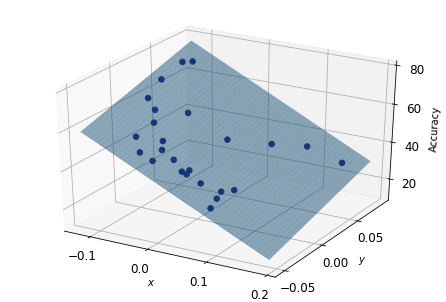

In [11]:
def get_value(data_dict, data_type, depth, mode="train"):
    if mode == "test":
        return data_dict[mode][data_type][depth]
    if data_type == "var_agaf_new/var_teacher":
        agaf_new = data_dict["train"]["var_agaf_new"][depth]
        teacher = data_dict["train"]["var_teacher"][depth]
        return agaf_new / teacher
    if data_type == "var_normal-agaf_new/var_teacher":
        normal_agaf_new = data_dict["train"]["var_normal-agaf_new"][depth]
        teacher = data_dict["train"]["var_teacher"][depth]
        return normal_agaf_new / teacher


def get_single_feature(model_size, chosen_data_types, chosen_depths):
    data_dict = load_obj(f"./data/reliability_cifar10/{model_size}_data.bin")
    features = []
    for depth in chosen_depths:
        for data_type in chosen_data_types:
            features.append(get_value(data_dict, data_type, depth))
    return features


def get_target(model_size, chosen_target_type):
    data_dict = load_obj(f"./data/reliability_cifar10/{model_size}_data.bin")
    return data_dict["test"][chosen_target_type][1]


def get_X_y(chosen_model_size, chosen_data_type, chosen_depths, chosen_target_type):
    X = []
    y = []
    for model_size in chosen_model_size:
        X.append(get_single_feature(model_size, chosen_data_type, chosen_depths))
        y.append(get_target(model_size, chosen_target_type))
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y


def pca_regression_visualize(X, y):
    from mpl_toolkits.mplot3d.axes3d import Axes3D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    reduced_X = pca.fit_transform(X)
    regr_model = linear_model.LinearRegression()
    regr_model.fit(reduced_X, y)
    plot_x = np.linspace(np.min(reduced_X[:, 0]) * 1.2, np.max(reduced_X[:, 0]) * 1.2, 100)
    plot_y = np.linspace(np.min(reduced_X[:, 1]) * 1.2, np.max(reduced_X[:, 1]) * 1.2, 100)
    plot_x, plot_y = np.meshgrid(plot_x, plot_y)
    plot_z = regr_model.coef_[0] * plot_x + regr_model.coef_[1] * plot_y + regr_model.intercept_
    fig = plt.figure()
    axes3d = Axes3D(fig)
    axes3d.tick_params(labelsize=12)
    axes3d.scatter(reduced_X[:, 0], reduced_X[:, 1], y, s=30, alpha=1.0, c="#1a237e")
    axes3d.plot_surface(plot_x, plot_y, plot_z, alpha=0.5)
    axes3d.xaxis.set_major_locator(MultipleLocator(0.1))
    axes3d.yaxis.set_major_locator(MultipleLocator(0.05))
    axes3d.zaxis.set_major_locator(MultipleLocator(20))
    axes3d.set_xlabel(r"$x$")
    axes3d.set_ylabel(r"$y$")
    axes3d.set_zlabel("Accuracy")
    plt.show()


def k_folder_validation(X_data, y_data, metric="RMSE"):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
    regr_model = linear_model.LinearRegression()
    regr_model.fit(X_train, y_train)
    y_train_pred = regr_model.predict(X_train)
    y_test_pred = regr_model.predict(X_test)
    if metric == "RMSE":
        return mean_squared_error(y_train_pred, y_train) ** 0.5, mean_squared_error(y_test_pred, y_test) ** 0.5
    elif metric == "MSE":
        return mean_squared_error(y_train_pred, y_train), mean_squared_error(y_test_pred, y_test)
    elif metric == "MAE":
        return mean_absolute_error(y_train_pred, y_train), mean_absolute_error(y_test_pred, y_test)


def test(X_data, y_data, metric="MAE", times=1000):
    loss_train = 0
    loss_test = 0
    for _ in range(times):
        a, b = k_folder_validation(X_data, y_data, metric)
        loss_train += a
        loss_test += b
    loss_train /= times
    loss_test /= times
    print(f"Train {metric} {loss_train}")
    print(f"Test {metric} {loss_test}")


def regression():
    all_models = ["resnet8", "resnet14", "resnet20", "resnet32", "resnet44"]
    all_sizes = [200, 500, 1000, 2000, 5000]
    chosen_model_size = []
    for model in all_models:
        for size in all_sizes:
            chosen_model_size.append(f"{model}_{size}")
    chosen_data_type = ["var_agaf_new/var_teacher", "var_normal-agaf_new/var_teacher"]

    chosen_depths = [1, 2, 4, 8]
    chosen_target_type = "teacher_acc"
    X, y = get_X_y(chosen_model_size=chosen_model_size, chosen_data_type=chosen_data_type,
                   chosen_depths=chosen_depths, chosen_target_type=chosen_target_type)
    print("target ranging from", np.min(y), "to", np.max(y), "and STD is", np.std(y))
    regr_model = linear_model.LinearRegression()
    regr_model.fit(X, y)
    save_obj(regr_model, "model_8d.pkl")
    y_pred = regr_model.predict(X)
    print(f"RMSE {mean_squared_error(y_pred, y) ** 0.5}")
    print(f"R^2 {regr_model.score(X, y)}")
    test(X, y)

    pca_regression_visualize(X, y)
    
regression()